In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import folium

from tqdm import tqdm_notebook
from glob import glob
from tqdm.auto import tqdm
import pickle

import CaGeo.algorithms.SegmentFeatures as sf
import CaGeo.algorithms.BasicFeatures as bf
from shapely import LineString
from shapely.ops import unary_union, polygonize

def count_self_intersections(latitudes, longitudes):
    line = LineString(zip(longitudes, latitudes))
    multi_line = unary_union(line)
    intersections = list(polygonize(multi_line))
    return len(intersections)

import umap
import warnings
warnings.filterwarnings("ignore")

def print_umap(dist_matrix, alpha=.1, labels=None):

    n_neighbors_list = [3, 5, 10, 30, 50, 100, 200, 500, 1000]
    min_dist_list = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
    
    _, axs = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(25, 20))
    
    for i, n_neighbors in enumerate(tqdm(n_neighbors_list)):
        for j, min_dist in enumerate(min_dist_list):
            reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, n_jobs=128)
            embedding = reducer.fit_transform(dist_matrix)
            axs[i, j].scatter(embedding[:, 0], embedding[:, 1], alpha=alpha, s=2, c=labels)
            axs[i, j].set_title(f'n={n_neighbors} d={min_dist}')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

In [2]:
from geoletrld.distances import ShapeDistance, RotatingGenericDistance, EuclideanDistance
from geoletrld.partitioners import FeaturePartitioner, GeohashPartitioner

In [3]:
with open('Data/Not_Resampled/trj.trj', 'rb') as fd:
    trajectories = pickle.load(fd)

In [4]:
candidate_geolets = FeaturePartitioner(feature="distance", threshold=10 * 1000, overlapping=.3, verbose=True).transform(trajectories)

len(candidate_geolets)

  0%|          | 0/71 [00:00<?, ?it/s]

12520

In [5]:
def straightness2(lat: np.ndarray, lon: np.ndarray, accurate=False):
    min_lat, max_lat = np.min(lat), np.max(lat)
    min_lon, max_lon = np.min(lon), np.max(lon)
    dE = bf.distance(np.array([min_lat, max_lat]), np.array([min_lon, max_lon]), accurate=accurate)
    L = bf.distance(lat, lon, accurate=accurate).sum()

    return (dE / L)[1]

additional_features = {
    "avg_speed": lambda x: np.mean(bf.speed(lat=x.latitude, lon=x.longitude, time=x.time)*3600),
    "std_accel": lambda x: np.mean(bf.acceleration(lat=x.latitude, lon=x.longitude, time=x.time)*3600),
    "distance_mean": lambda x: np.mean(bf.distance(lat=x.latitude, lon=x.longitude, accurate=False)*1000),
    "start2end_distance": lambda x: np.sum(bf.distance(lat=np.array([x.latitude[1], x.latitude[-1]]), 
                                                       lon=np.array([x.longitude[1], x.longitude[-1]])*3600, accurate=False)),

    "straightness": lambda x: sf.straightness(lat=x.latitude, lon=x.longitude),
    "straightness2": lambda x: straightness2(lat=x.latitude, lon=x.longitude),
    "sinuosity": lambda x: sf.sinuosity(lat=x.latitude, lon=x.longitude),
    "intensityUse": lambda x: sf.intensityUse(lat=x.latitude, lon=x.longitude),

    "intersections": lambda x: count_self_intersections(x.latitude, x.longitude),
}

if False and os.path.exists('Geolet 2.0. 20250427_features.csv'):
    df_features = pd.read_csv('Geolet 2.0. 20250427_features.csv')
else:
    new_data = dict()
    for feature_name, feature_function in tqdm(additional_features.items(), position=0):
        res_list = []
        
        for shapelet in tqdm(candidate_geolets.values(), position=1, leave=False):
            res_list.append(feature_function(shapelet))
    
        new_data[feature_name] = res_list
    df_features = pd.DataFrame.from_dict(new_data)

df_features.describe()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

avg_speed     std_accel  distance_mean  start2end_distance  \
count  12520.000000  1.252000e+04   12520.000000        12520.000000   
mean      11.545952  1.297401e+00     257.028859         5115.487499   
std        5.452017  1.046928e+00     451.677618         2855.177317   
min        0.000045  3.482001e-10       0.400012            0.000000   
25%        5.839914  5.037858e-01      40.985635         2610.753326   
50%       13.297104  1.188006e+00      63.624517         5569.155028   
75%       16.274677  1.730172e+00     244.566281         7653.200426   
max       23.908791  8.200633e+00    3331.217156         9717.880103   

       straightness  straightness2     sinuosity  intensityUse  intersections  
count  12520.000000   12520.000000  12520.000000  12520.000000   12520.000000  
mean       0.832771       0.884994      1.240419    251.531057     531.006550  
std        0.274991       0.184634      2.293575    667.902902    8578.326971  
min        0.000212       0.003101      0.011147    127.810858       0.000000  
25%        0.771487       0.831444      0.635873    137.747945       0.000000  
50%        0.990019       0.990865      0.775054    178.487838       0.000000  
75%        0.998354       0.998389      1.175500    266.330712       0.000000  
max        1.000000       1.000000     71.773069  46021.145297  395031.000000

In [6]:
df_features.to_csv('Geolet 2.0. 20250427_features.csv', index=None)

In [7]:
dist_function = ShapeDistance(agg=np.sum, resolution=(480, 480), use_accumulator=False, 
                                            use_fft=False, angle_step=1, n_jobs=1024, verbose=True)

In [8]:
!ulimit -n 1000000

In [9]:
from skimage.transform import hough_line
import scipy

angle_step = 1
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, int(180 / angle_step), endpoint=False)

transformed_candidate_geolets = dict()

for geo_id, geo in tqdm(candidate_geolets.items()):
    img = ShapeDistance.draw_image(geo, resolution=(480, 480), padding=1, verbose=False)
    h, theta, d = hough_line(np.array(img), theta=tested_angles)
    h = np.log(1 + h)
    h_sum = h.sum(axis=0)
    fft = np.abs(scipy.fft.fft(h_sum))
    transformed_candidate_geolets[geo_id] = (geo, img, h, h_sum, fft)

  0%|          | 0/12520 [00:00<?, ?it/s]

In [10]:
dist_matrix_img_fft = np.vstack([fft for geoelt_id, (lines, img, h, h_sum, fft) in tqdm(transformed_candidate_geolets.items())])
dist_matrix_img_h = np.vstack([h.flatten() for geoelt_id, (lines, img, h, h_sum, fft) in tqdm(transformed_candidate_geolets.items())])
dist_matrix_img_h_sum = np.vstack([h_sum for geoelt_id, (lines, img, h, h_sum, fft) in tqdm(transformed_candidate_geolets.items())])

print(dist_matrix_img_fft.shape)
print(dist_matrix_img_h.shape)
print(dist_matrix_img_h_sum.shape)

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

  0%|          | 0/12520 [00:00<?, ?it/s]

(12520, 180)
(12520, 244620)
(12520, 180)


In [11]:
dist_matrix_new = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dist_matrix_img_h_sum, metric='euclidean'))

  0%|          | 0/9 [00:00<?, ?it/s]

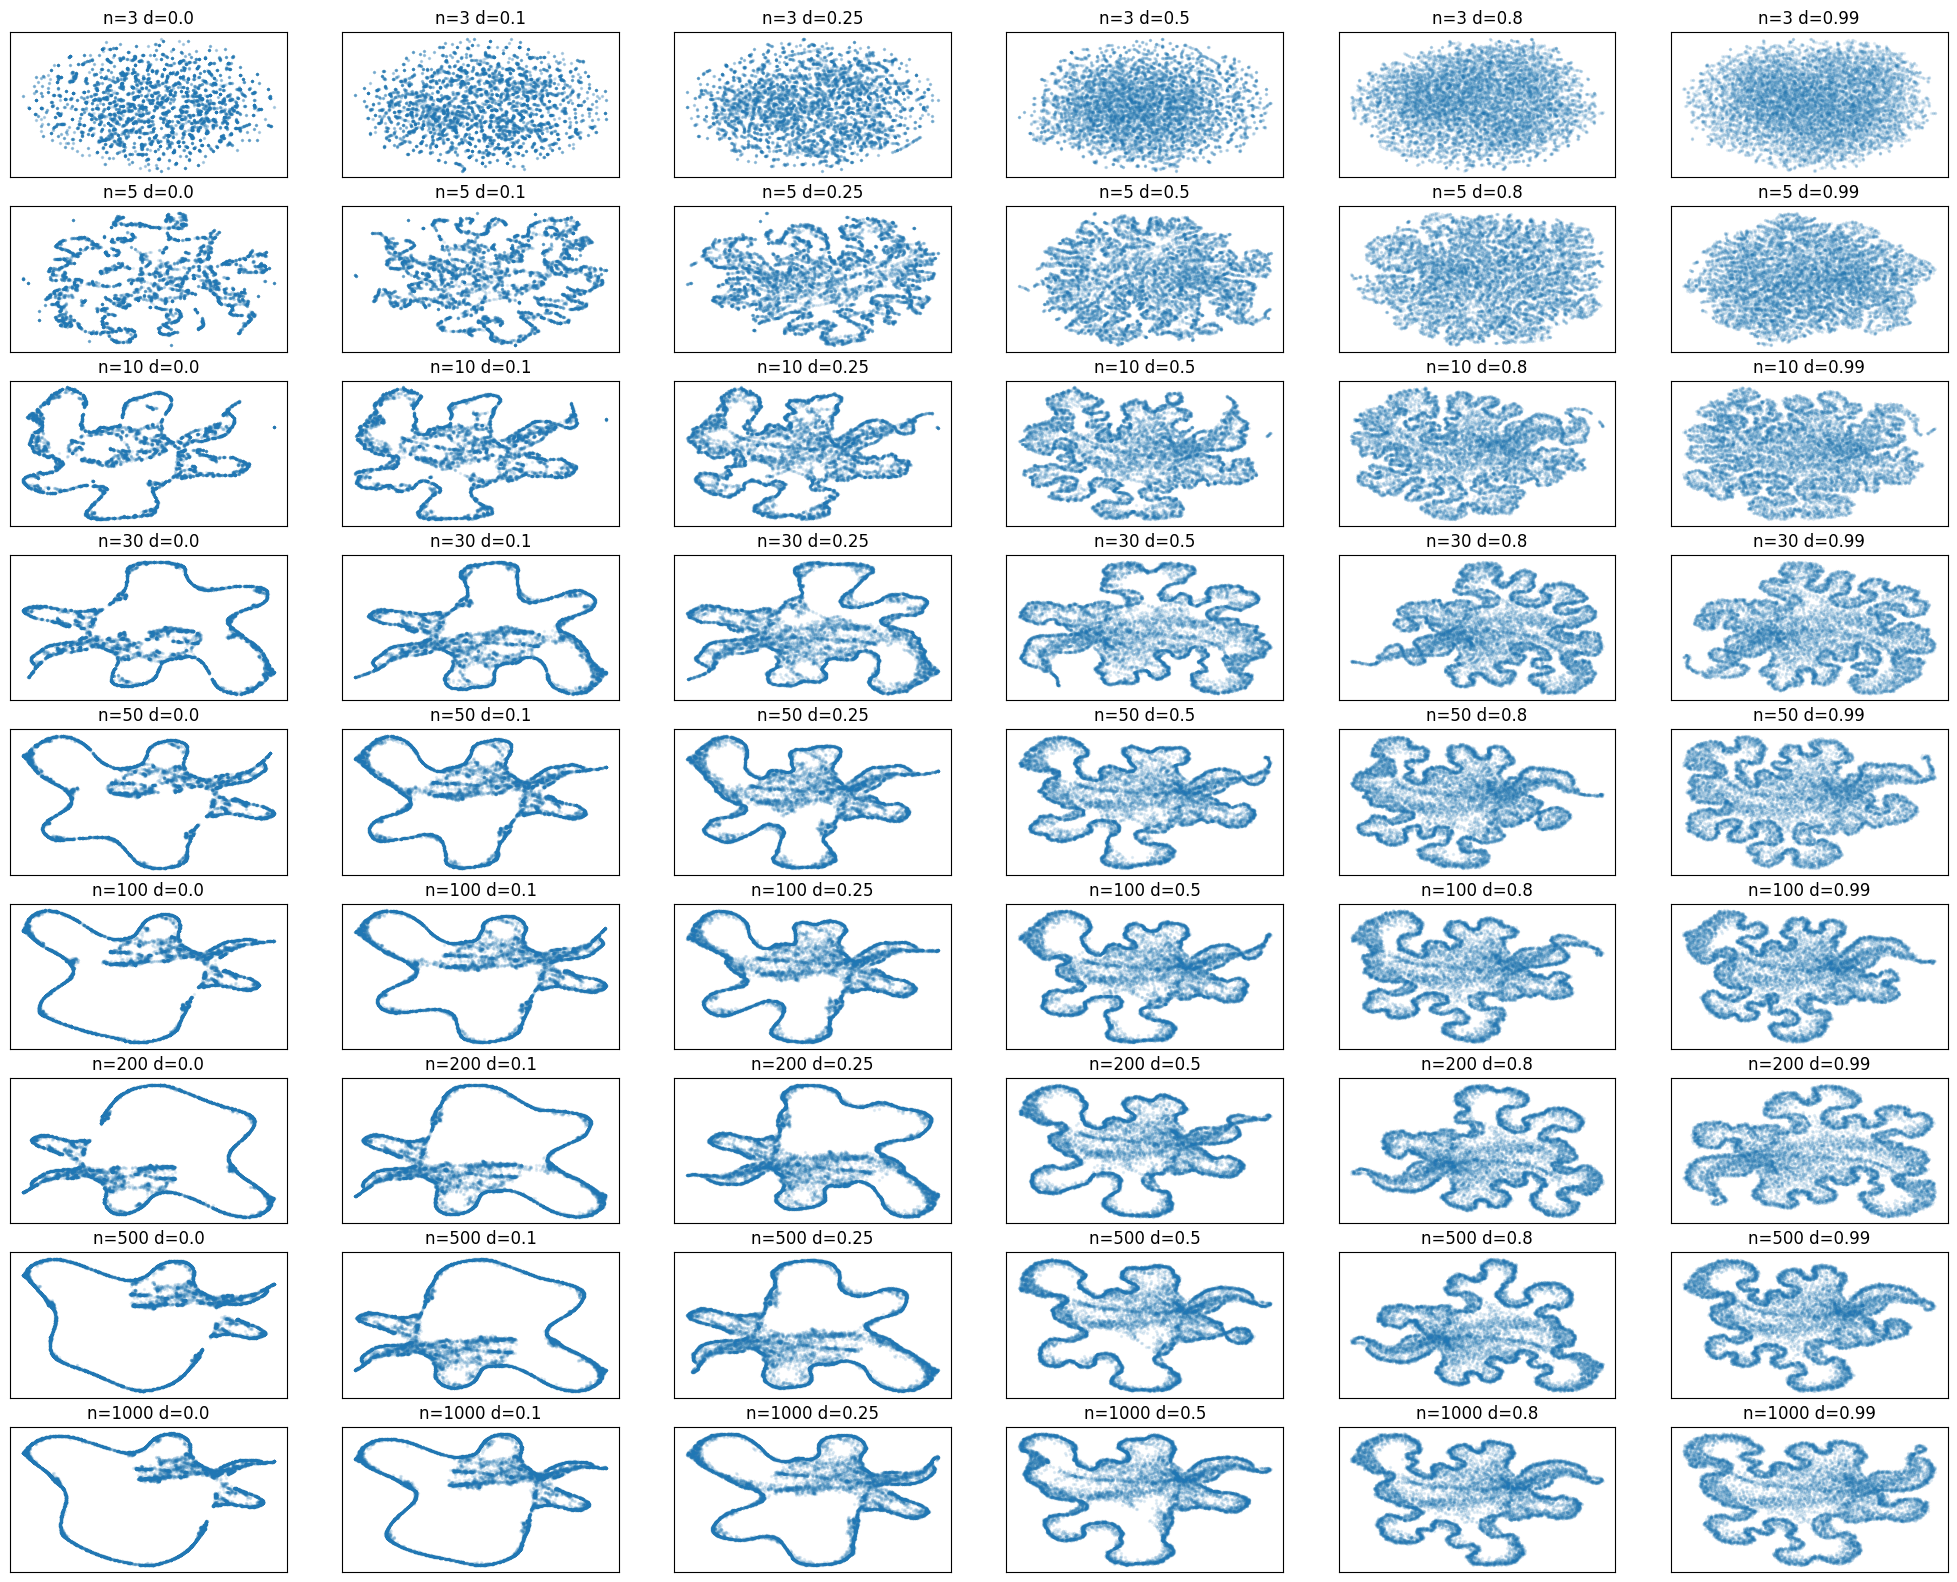

In [12]:
print_umap(dist_matrix_new)

In [13]:
from sklearn.cluster import OPTICS

optics_labels_minmax = OPTICS(n_jobs=256, metric='precomputed').fit_predict(dist_matrix_new)

len(np.unique(optics_labels_minmax))

185

In [ ]:
# It seems stable. On the subset (10km shapes, not overlapping) OPTICS found 143 shapes, 

In [24]:
import math

def get_medoids(dist_matrix, labels):
    unique_labels = np.unique(labels)
    masks = labels[:, None] == unique_labels
    medoids = []
    for i, mask in enumerate(tqdm(masks.T)):
        dists = dist_matrix[mask][:, mask]
        idx = np.argmin(dists.sum(axis=1))
        medoids.append((np.where(mask)[0][idx], dists[idx]))
    return medoids

def plot_cluster(dist_matrix, labels, geolets, geolets_keys):
    medoids = get_medoids(dist_matrix, labels)

    fig, axes = plt.subplots(math.ceil(len(medoids)**.5), math.ceil(len(medoids)**.5), figsize=(15, 15))
    axes = axes.flatten()
    
    for ax, (geolet_id, _) in zip(axes, tqdm(medoids)):
        geolet_data = geolets[geolets_keys[geolet_id]]
        ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
        ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='tab:red')
        ax.scatter(geolet_data.longitude[-1], geolet_data.latitude[-1], color='tab:green')
        ax.set_title(geolet_id, fontsize=8)
        ax.set_aspect('equal')  # stessa scala per x e y
        ax.axis('off')  # opzionale, per rimuovere gli assi
    
    plt.tight_layout()

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

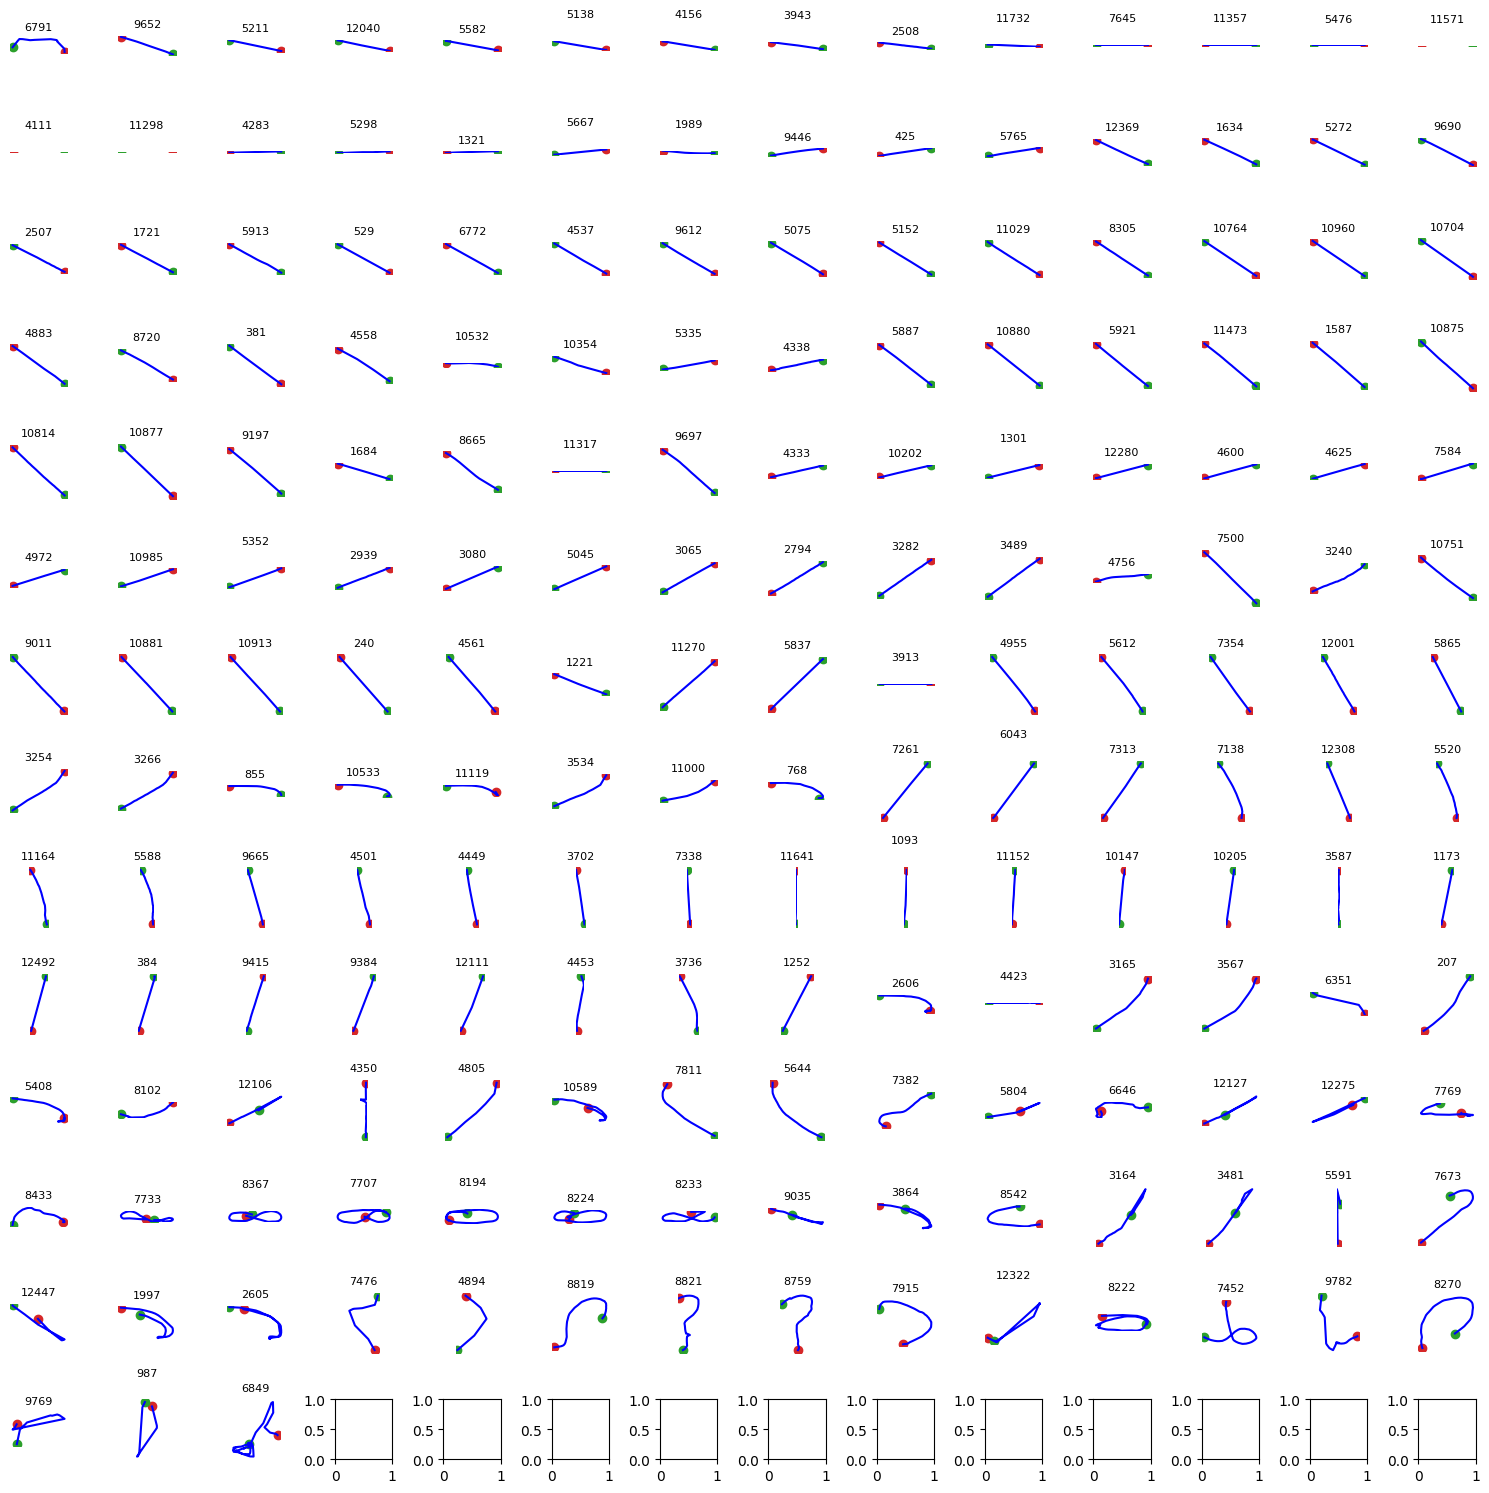

In [25]:
plot_cluster(dist_matrix_new, optics_labels_minmax, candidate_geolets, np.array(list(candidate_geolets.keys())))

In [37]:
def get_medoids_k(dist_matrix, labels, k=1):
    unique_labels = np.unique(labels)
    masks = labels[:, None] == unique_labels
    medoids = []
    for i, mask in enumerate(masks.T):
        dists = dist_matrix[mask][:, mask]
        sums = dists.sum(axis=1)
        k_eff = min(k, len(sums))
        topk_idx = np.argpartition(sums, k_eff-1)[:k_eff]
        topk_sorted = topk_idx[np.argsort(sums[topk_idx])]
        true_idx = np.where(mask)[0][topk_sorted]
        medoids.append(list(zip(true_idx, sums[topk_idx])))
    return medoids

medoids = get_medoids_k(dist_matrix_new, optics_labels_minmax, 10)

idx = []
for medoids_sub in medoids:
    for i, _ in medoids_sub:
        idx.append(i)

(array([    0,     1,     2,     3,     4,     5,     6,     9,    10,
          11,    12,    13,    14,    16,    18,    19,    20,    23,
          29,    38,    48,    60,   148,   169,   191,   207,   216,
         366,   440,   526,   542,   679,   768,   779,   805,   806,
         814,   958,   970,   991,   993,  1123,  1618,  1838,  1908,
        2247,  2498,  2537,  2969,  3133,  3135,  3450,  3572,  6070,
        6074,  6403,  6408,  6543,  7838,  7962,  9139,  9523, 11648,
       28852, 33183, 34360, 44030]), array([1160,   76,   28,   10,    9,    3,    3,    3,    2,    2,    2,
          1,    2,    1,    1,    1,    1,    2,    1,    1,    1,    1,
          1,    1,    2,    1,    1,    2,    1,    1,    1,    1,    1,
          2,    1,    2,    2,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1]))


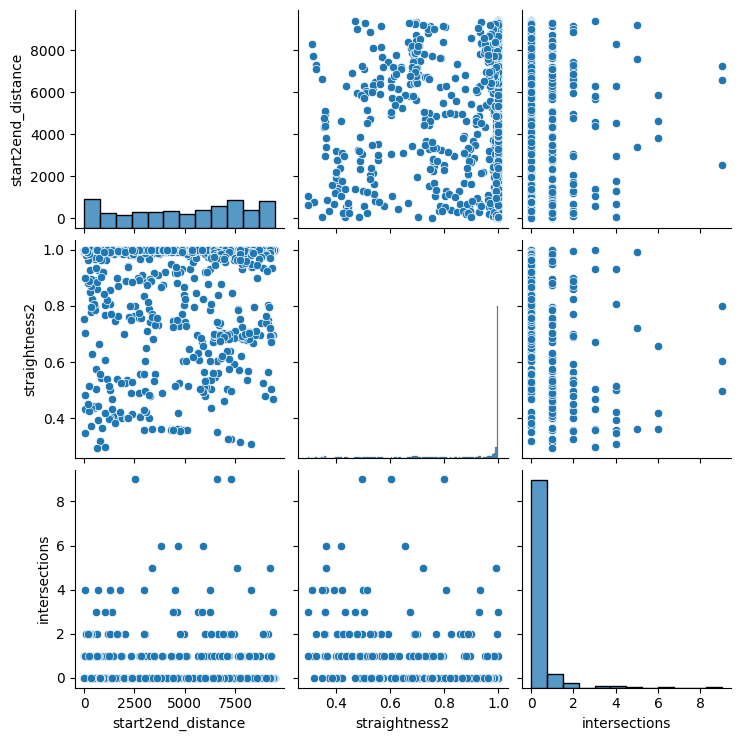

In [38]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

cols = ['start2end_distance', 'straightness2', 'intersections']

df_features_sub = df_features[cols].iloc[idx]
print(np.unique(df_features_sub.intersections, return_counts=True))
#df_features_sub.intersections = np.log2(1+df_features_sub.intersections.values)

df_features_sub_idx = np.where(df_features_sub.intersections < 10)
df_features_sub = df_features_sub[df_features_sub.intersections < 10]

sns.pairplot(df_features_sub)
plt.show()

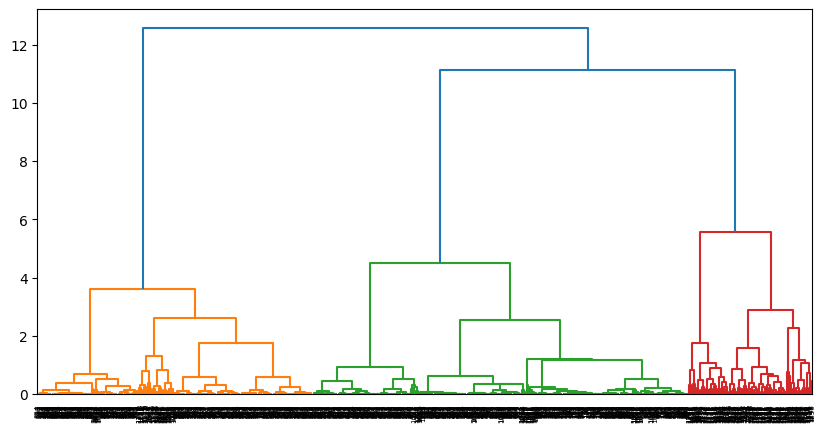

In [39]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df_features_sclaed = pd.DataFrame(MinMaxScaler().fit_transform(df_features_sub), columns=df_features_sub.columns)

Z = linkage(df_features_sclaed.values, method='ward')  # single complete

plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.show()

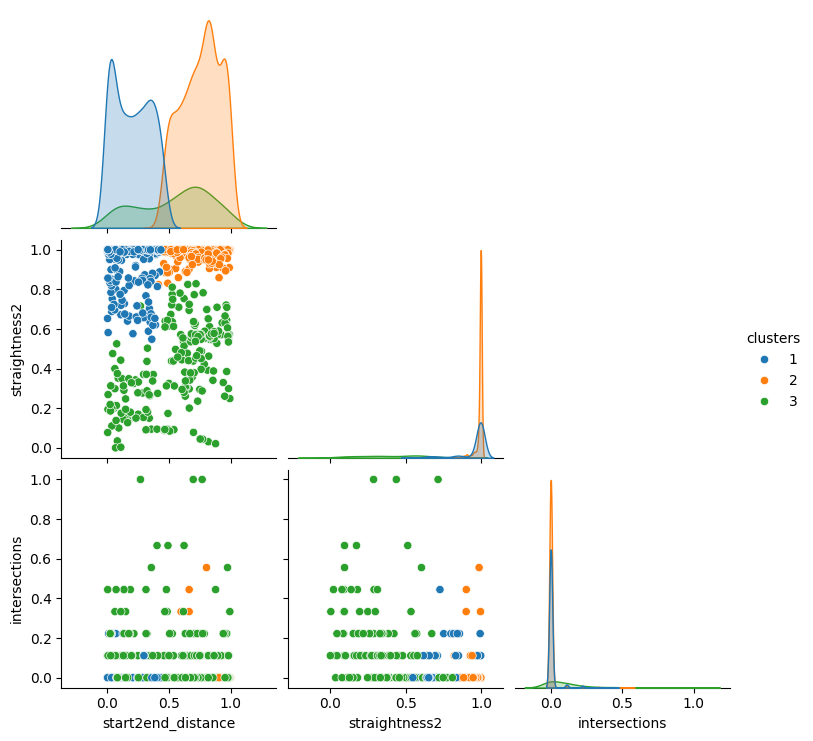

In [47]:
labels = fcluster(Z, t=3, criterion='maxclust')

df_features_sclaed_clu = df_features_sclaed.copy()
df_features_sclaed_clu['clusters'] = labels

sns.pairplot(df_features_sclaed_clu, hue='clusters', corner=True, palette='tab10')
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

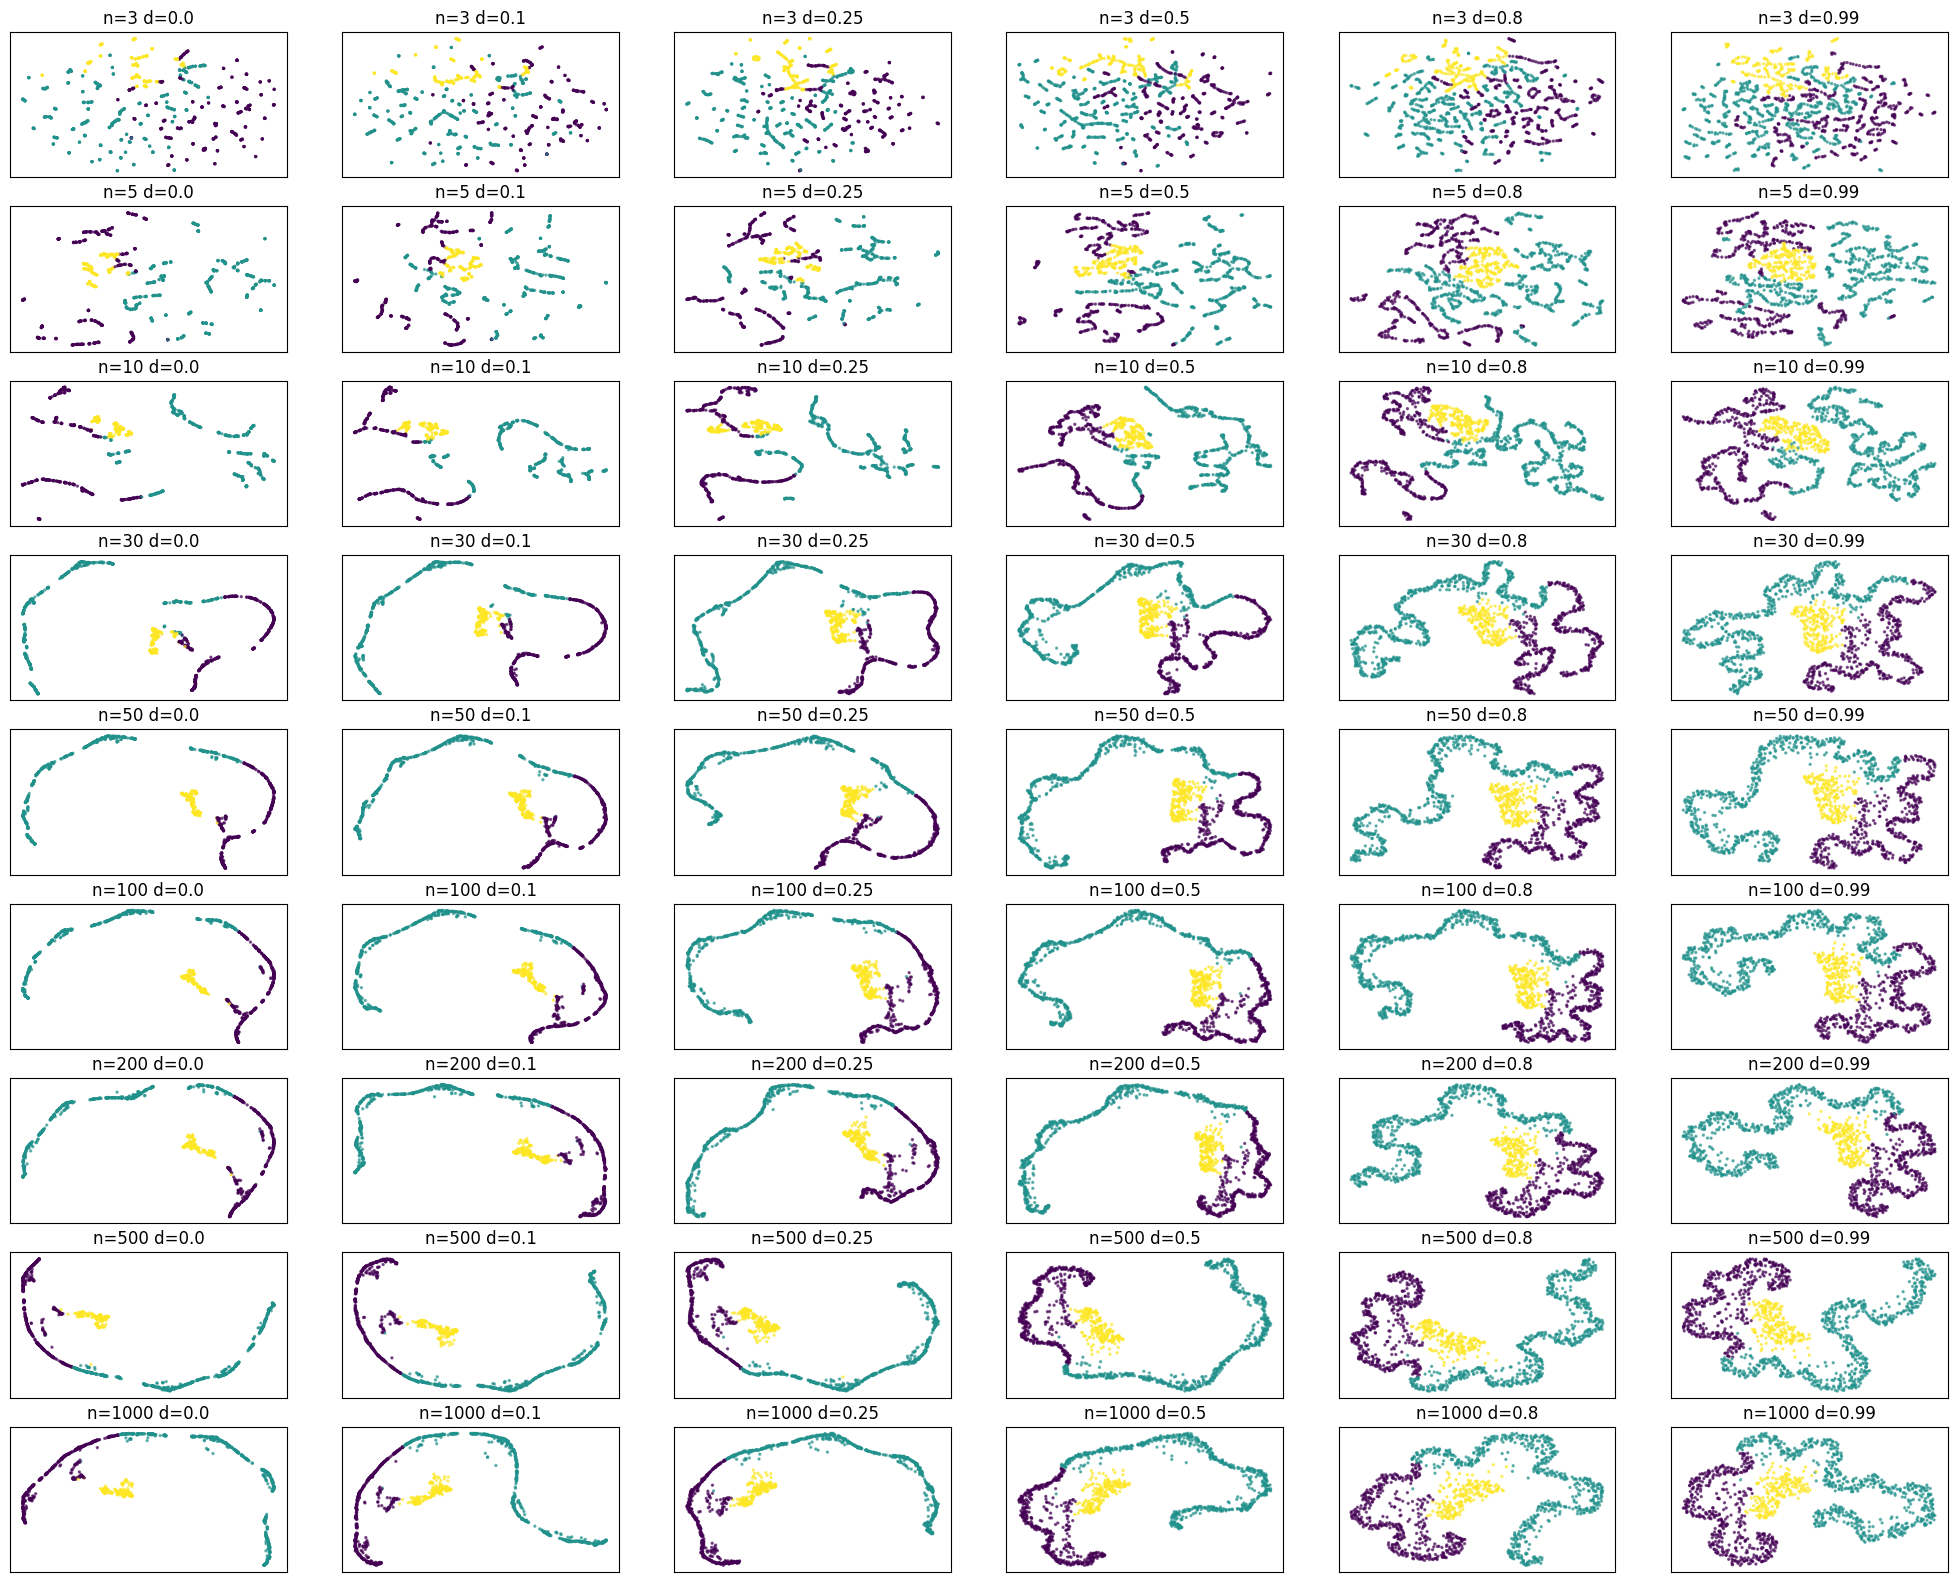

In [48]:
print_umap(df_features_sclaed, alpha=.6, labels=labels)

  0%|          | 0/1292 [00:00<?, ?it/s]

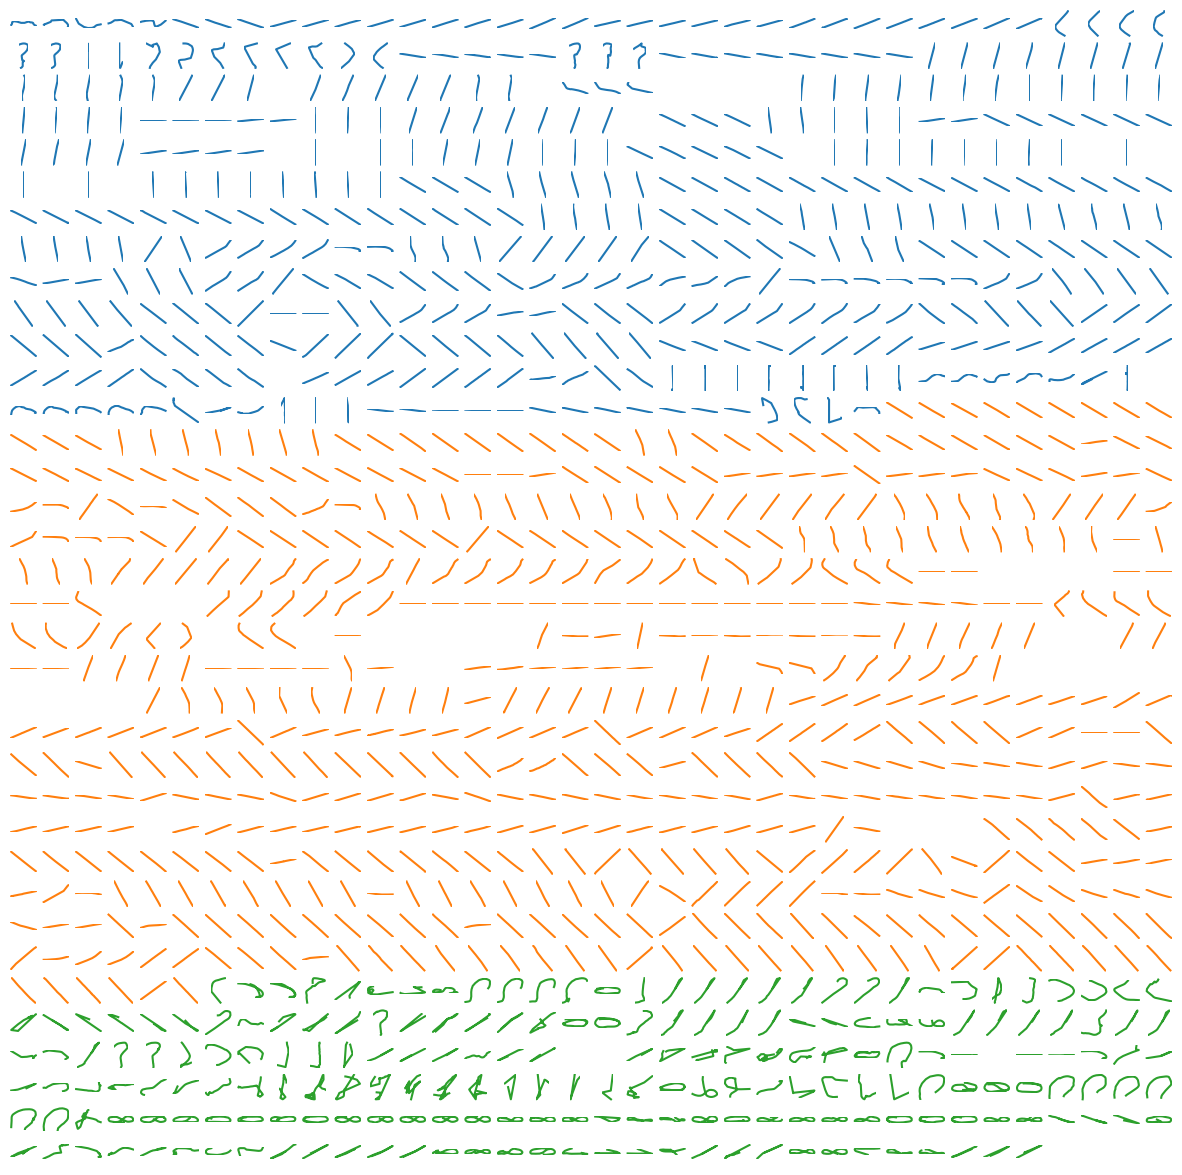

In [49]:
colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
}

fig, axes = plt.subplots(math.ceil(len(labels)**.5), math.ceil(len(labels)**.5), figsize=(15, 15))
axes = axes.flatten()

labels_sorted_idx = np.argsort(labels)


for i, ax in zip(tqdm(labels_sorted_idx), axes):
    label = labels[i]
    geolet_key = np.array(list(candidate_geolets.keys()))[idx][df_features_sub_idx][i]
    geoler_data = candidate_geolets[geolet_key]
    ax.plot(geoler_data.longitude, geoler_data.latitude, c=colors[label])
    ax.set_aspect('equal')  # stessa scala per x e y

for ax in axes:
    ax.axis('off')

In [ ]:
# >= 10 ?

(array([    0,     1,     2,     3,     4,     5,     6,     9,    10,
          11,    12,    13,    14,    16,    18,    19,    20,    23,
          29,    38,    48,    60,   148,   169,   191,   207,   216,
         366,   440,   526,   542,   679,   768,   779,   805,   806,
         814,   958,   970,   991,   993,  1123,  1618,  1838,  1908,
        2247,  2498,  2537,  2969,  3133,  3135,  3450,  3572,  6070,
        6074,  6403,  6408,  6543,  7838,  7962,  9139,  9523, 11648,
       28852, 33183, 34360, 44030]), array([1160,   76,   28,   10,    9,    3,    3,    3,    2,    2,    2,
          1,    2,    1,    1,    1,    1,    2,    1,    1,    1,    1,
          1,    1,    2,    1,    1,    2,    1,    1,    1,    1,    1,
          2,    1,    2,    2,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1]))


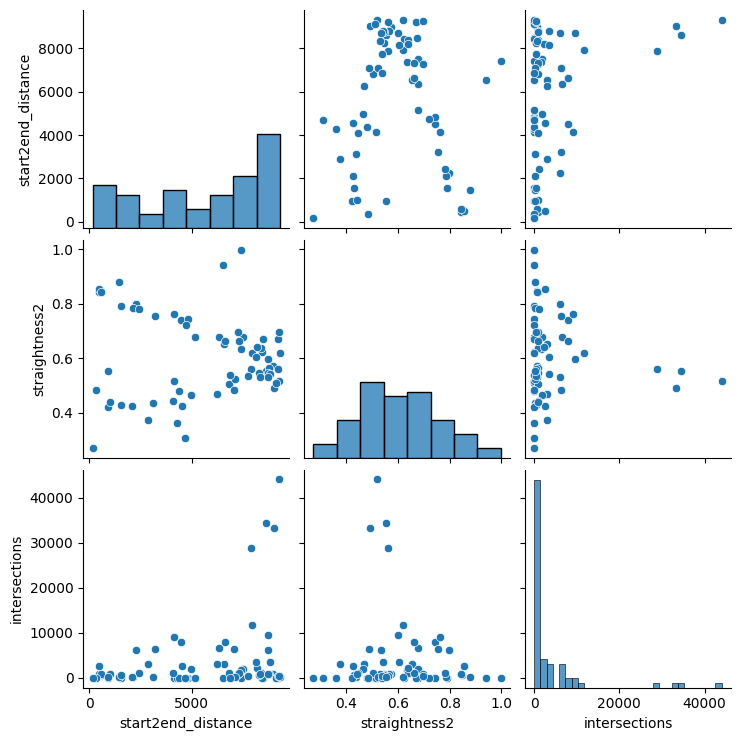

In [51]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler

cols = ['start2end_distance', 'straightness2', 'intersections']

df_features_sub = df_features[cols].iloc[idx]
print(np.unique(df_features_sub.intersections, return_counts=True))
#df_features_sub.intersections = np.log2(1+df_features_sub.intersections.values)

df_features_sub_idx = np.where(df_features_sub.intersections >= 10)
df_features_sub = df_features_sub[df_features_sub.intersections >= 10]

sns.pairplot(df_features_sub)
plt.show()

In [52]:
df_features_sub_idx

(array([ 452,  679,  684,  726,  754,  755,  756,  757,  762,  763,  777,
         778,  779,  780,  781,  782,  783,  784, 1012, 1014, 1015, 1017,
        1018, 1019, 1021, 1024, 1053, 1054, 1055, 1056, 1057, 1058, 1059,
        1060, 1061, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102,
        1103, 1127, 1160, 1176, 1203, 1204, 1205, 1206, 1207, 1208, 1244,
        1248, 1250, 1251, 1252, 1253, 1255, 1256, 1257, 1258, 1259, 1303,
        1352, 1354, 1355]),)

  0%|          | 0/69 [00:00<?, ?it/s]

[]

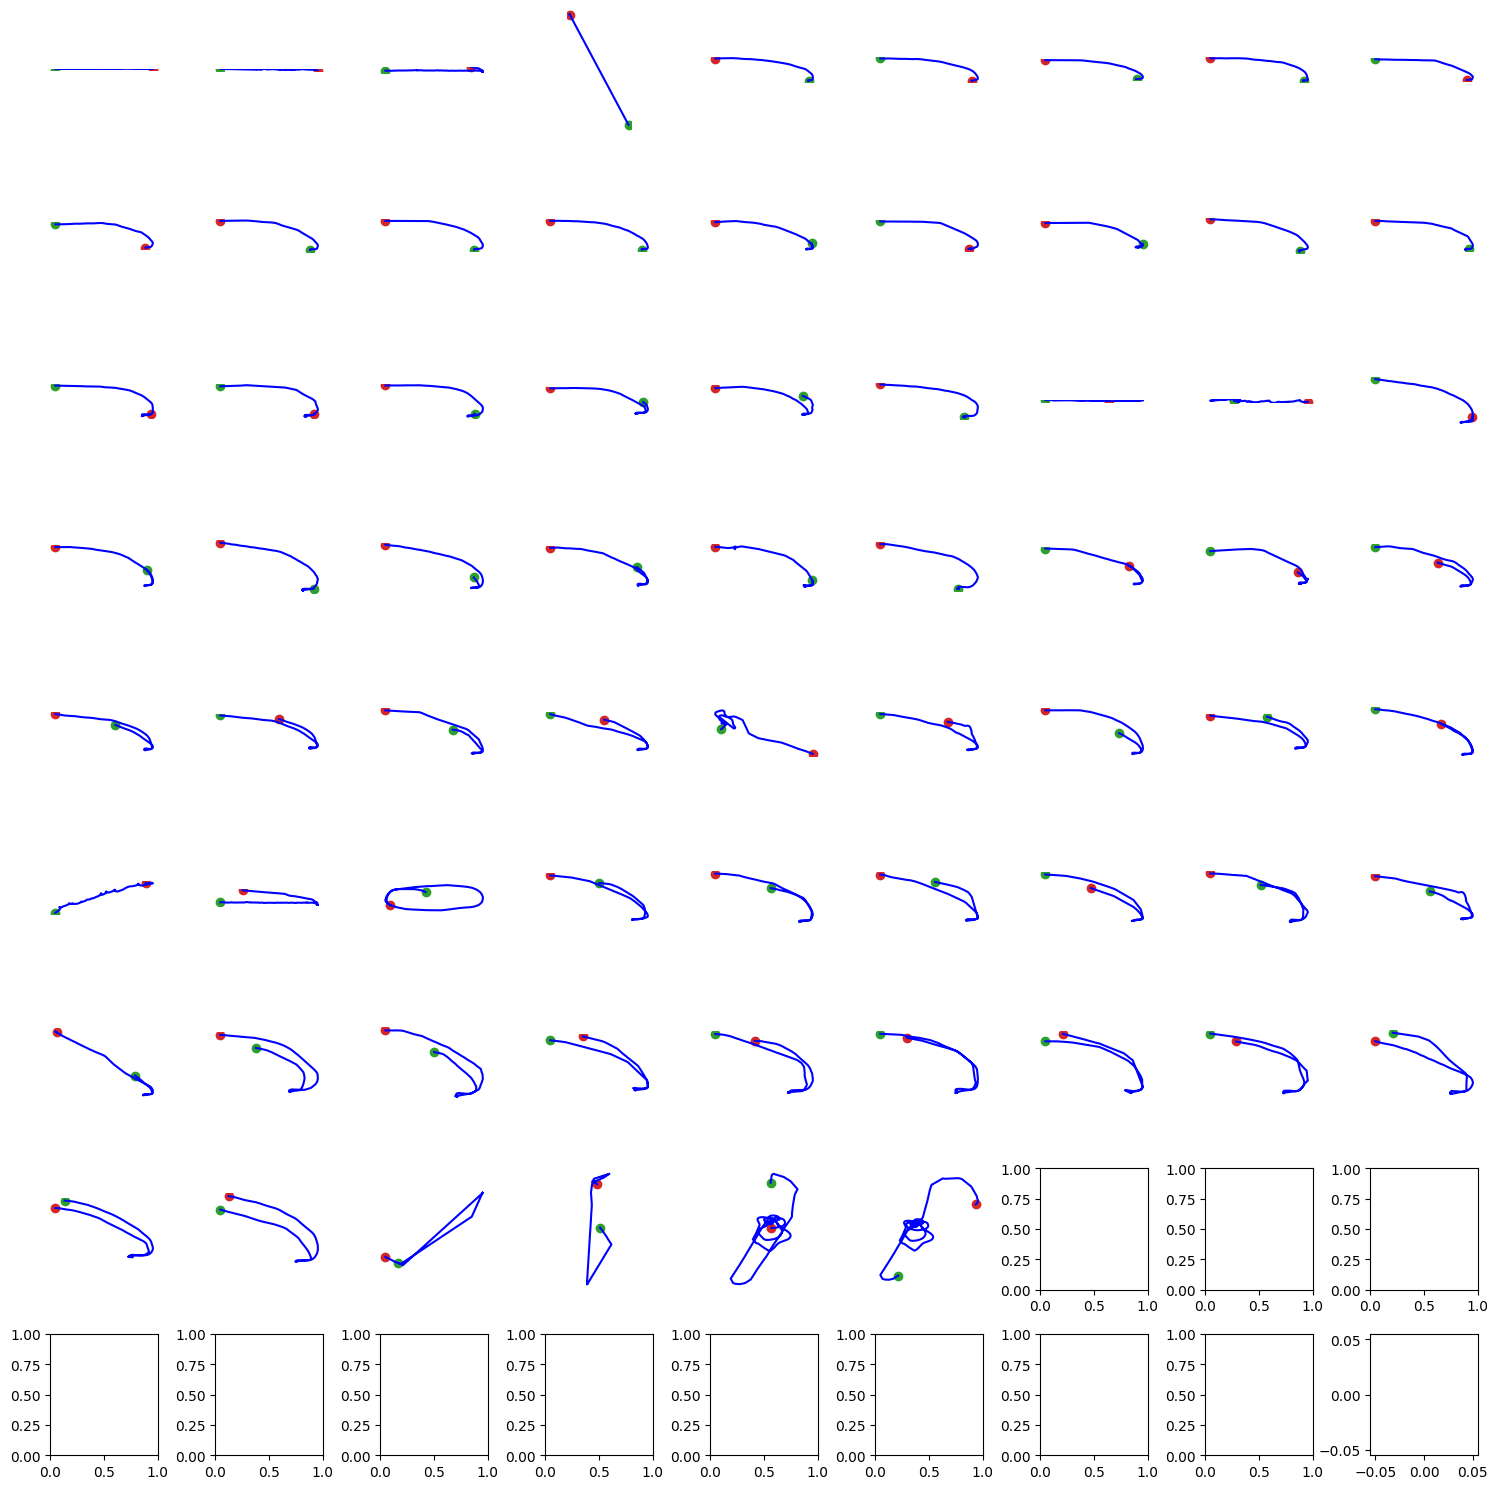

In [60]:
fig, axes = plt.subplots(math.ceil(len(df_features_sub_idx[0])**.5), math.ceil(len(df_features_sub_idx[0])**.5), figsize=(15, 15))
axes = axes.flatten()

for ax, pos in zip(axes, tqdm(df_features_sub_idx[0])):
    geolets_keys = np.array(list(candidate_geolets.keys()))
    geolet_data = candidate_geolets[geolets_keys[idx][pos]]
    ax.plot(geolet_data.longitude, geolet_data.latitude, color='blue')
    ax.scatter(geolet_data.longitude[0], geolet_data.latitude[0], color='tab:red')
    ax.scatter(geolet_data.longitude[-1], geolet_data.latitude[-1], color='tab:green')
    ax.set_aspect('equal')  # stessa scala per x e y
    ax.axis('off')  # opzionale, per rimuovere gli assi

plt.tight_layout()
plt.plot()

In [70]:
to_plot = geolets_keys[idx][df_features_sub_idx[0]]

from matplotlib import colors

def plot_folium(geolet_sub, m=None):
    if m is None:
        m = folium.Map(location=[geolet_sub.latitude[0], geolet_sub.longitude[0]], zoom_start=17)
    
    segment = list(zip(geolet_sub.latitude, geolet_sub.longitude))
    folium.PolyLine(segment, weight=2, opacity=0.7).add_to(m)
        
    return m

m=None
for to_plot_el in to_plot:
    m = plot_folium(candidate_geolets[to_plot_el], m)

display(m)

In [69]:
candidate_geolets[to_plot_el]